# 1. GBM (Gradient Boosting Machine)
## 타이타닉 데이터셋 다운로드 및 전처리
실행하셔서 실행 결과를 확인하시면 됩니다.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 타이타닉 데이터셋 다운로드
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# 결측치 처리
imputer = SimpleImputer(strategy='mean')  # 수치형 데이터의 결측치는 평균으로 대체
data['Age'] = imputer.fit_transform(data[['Age']])
data['Fare'] = imputer.fit_transform(data[['Fare']])
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])  # 범주형 데이터는 최빈값으로 대체

# 범주형 변수 인코딩
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])  # 성별을 0과 1로 인코딩
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])  # 승선 항구를 숫자로 인코딩

# 필요없는 열 제거 (PassengerId, Name, Ticket, Cabin)
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# 데이터 확인
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## 1) GBM 학습 시간 측정
execution time 앞 주석을 제거하시고 코드를 입력하시면 됩니다.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time

# 데이터 분리
X = data.drop(columns=['Survived'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GBM 학습 및 시간 측정
gbm = GradientBoostingClassifier()
start_time = time.time()
gbm.fit(X_train, y_train)
end_time = time.time()

execution_time = end_time - start_time

print(f"GBM 학습 시간: {execution_time} 초")

GBM 학습 시간: 0.5628914833068848 초


## 2) GridSearchCV를 이용한 하이퍼파라미터 최적화

다음은 하이퍼파라미터의 역할과 초기화해야 값들입니다.
참고하여 param_grid를 초기화해주세요.
1. n_estimators  
역할: 모델이 학습할 트리(결정 트리)의 개수를 의미합니다. 트리의 개수가 많을수록 모델이 더 복잡해질 수 있으며, 학습 시간이 늘어납니다.  
테스트할 값: [100, 200]  

2. learning_rate  
역할: 학습 단계에서 모델이 얼마나 빠르게 업데이트되는지를 결정하는 학습률입니다. 작은 값은 느리게 학습하지만 더 정밀하게 조정되고, 큰 값은 빠르게 학습하지만 성능이 떨어질 수 있습니다.
테스트할 값: [0.05, 0.1]  

3. max_depth  
역할: 각 트리의 최대 깊이를 의미합니다. 트리가 깊을수록 모델이 복잡해져 더 많은 패턴을 학습할 수 있지만, 과적합의 위험도 커집니다.  
테스트할 값: [3, 5]  

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 설정
param_grid = {
    'n_estimators':[100,200],
    'learning_rate':[0.05,0.1],
    'max_depth':[3,5]
}

# GridSearchCV로 최적 파라미터 탐색
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f"최적 하이퍼파라미터: {grid_search.best_params_}")

최적 하이퍼파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


## 3) 최적화된 GBM 모델 성능 평가

In [ ]:
# 최적화된 GBM 모델 성능 평가
accuracy = grid_search.score(X_test, y_test)
print(f"테스트 데이터 정확도: {accuracy}")

테스트 데이터 정확도: 0.8044692737430168


## 4) GBM에서 학습 시간이 길어질 수 있는 요인을 하이퍼파라미터와 관련하여 간단하게 서술해 주세요.

GBM은 'learning rate' 이 너무 작으면 수행시간이 길어질 수 있다. 또한, 여러 개의 약한 학습기를 순차적으로 학습하며 가중치를 부여하기 때문에 'n_estimators' 가 크면 수행 시간이 오래 걸린다. XGBoost는 이러한 점을 보완하여 병렬로 학습을 수행한다.

## 5) GBM과 Random Forest의 차이점은 무엇일지 간단하게 서술해 주세요.   
힌트 : 직렬/병렬과 관련하여 학습 성능과 속도를 비교해 주세요.

GBM은 여러 개의 학습기를 직렬로 학습하여 수행 속도가 느리지만 잘못된 데이터에 가중치를 부여하기 때문에 랜덤 포레스트에 비해 성능이 좋다. 반면에, Random Forest는 같은 알고리즘으로 여러 개의 분류기를 만드는 병렬 처리가 일어나기 때문에 수행 속도가 빠르다.

# 2. XGBoost

## 1) dtrain, dtest 변환하기

In [ ]:
import xgboost as xgb

# dtrain과 dtest 생성
# 아래 주석을 제거하고 답을 입력해 주세요.
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

## 2) 하이퍼파라미터 기본 설정
다음은 하이퍼파라미터의 역할과 초기화해야 값들입니다.
참고하여 param을 초기화해주세요.
1. max_depth  
역할: 각 트리의 최대 깊이를 설정합니다. 트리의 깊이가 깊을수록 모델은 더 복잡한 패턴을 학습할 수 있지만, 과적합의 위험도 커집니다.  
설정 값: 3  

2. eta (learning_rate)  
역할: 학습률을 설정하며, 학습 단계에서 모델이 얼마나 빠르게 가중치를 업데이트할지를 결정합니다. 작은 값은 학습을 천천히 진행하며 더 정밀하게 최적화되고, 큰 값은 빠르게 수렴하지만 성능이 불안정할 수 있습니다.    
설정 값: 0.1     

3. objective
역할: 모델이 해결할 문제 유형을 지정합니다. 여기서는 이진 분류 문제이므로 'binary:logistic'을 사용하여 로지스틱 회귀 기반의 이진 분류를 수행합니다.  
설정 값: 'binary:logistic' (이진 분류)  

4. eval_metric
역할: 모델의 성능을 평가할 메트릭을 설정합니다. 여기서는 'logloss'를 사용하여 로지스틱 손실 함수를 기반으로 모델 성능을 평가합니다.
설정 값: 'logloss' (로지스틱 손실 함수를 사용한 평가)

In [ ]:
params = {
    'max_depth':3,
    'eta':0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss'
}

## 3) 하이퍼파라미터 최적화 (max_depth, eta 수정)
max_depth, eta 값을 각각 5, 0.05로 수정하여 최적화를 시도해봅니다.

In [ ]:
params_optimized = {
    'max_depth': 5,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

## 4) 후자(3번)의 경우가 왜 전자(2번)보다 최적화된 설정인지 예측해보세요.

과적합 문제를 해결하는 방법에는 eta를 낮추는 방법이 있다. 비록 3번의 'max_depth'이 2번 보다 크기 때문에 과적합 가능성이 높아지지만, 3번의 'eta'가 상대적으로 작기 때문에 최적화된 설정일 수 있다.

## 5) 최적화된 XGBoost 모델의 정확도 계산

In [ ]:
# 모델 학습
model_optimized = xgb.train(params_optimized, dtrain, num_boost_round=200)

# 테스트 데이터 예측
preds_optimized = model_optimized.predict(dtest)
accuracy_optimized = (preds_optimized.round() == y_test).mean()

print(f"최적화된 모델의 정확도: {accuracy_optimized}")

최적화된 모델의 정확도: 0.8212290502793296


## 6) XGBoost에서 learning_rate가 너무 크거나 작으면 발생할 수 있는 문제를 간단히 서술해주세요.

'learning_rate'이 너무 작으면 수행 시간이 오래 걸리고, 모든 약한 학습기가 완료되어도 최소 오류 값을 찾지 못할 수 있다. 반면에, 너무 크면 최소 오류 값을 지나칠 수 있으므로 성능이 떨어질 수 있다.

# 3. LightGBM

## 1) 피마 인디언 당뇨병 예측 데이터 세트를 불러와 train/test 세트로 분리해주세요.

아래의 링크에서 데이터 세트를 다운받아 주세요.

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# 피마 인디언 당뇨병 예측 데이터 셋 불러오기
diabetes_data = pd.read_csv(r'/content/drive/MyDrive/Euron/diabetes.csv')  # 파일 경로를 적어주세요.

# target value 분리
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# 데이터 셋을 train/test 데이터로 분리 (train:80%, test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=156, stratify=y, test_size=0.2)  # 코드를 완성해주세요

## 2) LightGBM 모델을 임포트하여 생성해주세요.

In [ ]:
# 파이썬 패키지 lightgbm에서 LGBMClassifier import
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# n_estimators를 500으로 설정
lgbm_wrapper = LGBMClassifier(n_estimators=500)

## 3) eval_set를 위에서 분리한 테스트 데이터로 설정해 evals에 저장하여 모델을 학습시켜 주세요.

In [ ]:
# eval_set를 위에서 분리한 테스트 데이터로 설정
evals = [(X_train, y_train)]

# 4.0.0 버전부터는 early_stopping_rounds와 verbose 파라미터 대신 callbacks를 사용합니다.
lgbm_wrapper.fit(X_train, y_train, callbacks=[early_stopping(stopping_rounds=100), log_evaluation(1)], eval_metric="auc", eval_set=evals)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's auc: 0.881011	training's binary_logloss: 0.606511
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's auc: 0.893914	training's binary_logloss: 0.571889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's auc: 0.897588	trai

LGBMClassifier(n_estimators=500)

## 4) 테스트 데이터로 예측을 수행해주세요.

In [ ]:
# test 데이터로 예측 수행
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
# 코드를 실행해주세요
from sklearn.metrics import roc_auc_score

# roc_auc_score 출력
roc_score = roc_auc_score(y_test, pred_proba, average='macro')
print('ROC_AUC: {0: .4f}'.format(roc_score))

ROC_AUC:  0.7709


## 5) 주어진 파라미터 후보들로 GridSearchCV를 이용해 하이퍼 파라미터 튜닝을 시행하세요.

params = {'num_leaves': [15, 32],
          'max_depth': [60, 100],
          'min_child_samples': [80, 100],
          'subsample': [0.4, 0.6]}

In [ ]:
# GridSearchCV로 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
# 힌트: 교재 p.261
params = {'num_leaves':[15,32],
          'max_depth':[60,100],
          'min_child_samples':[80,100],
          'subsample':[0.4,0.6]}
gridcv = GridSearchCV(lgbm_wrapper, param_grid=params, cv=3)
gridcv.fit(X_train, y_train)

# gridcv.best_params_로 최적 파라미터를 출력
print('GridSearchCV 최적 파라미터: ', gridcv.best_params_)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

## 6) 최적 파라미터를 적용하여 roc_auc_score를 측정해주세요.

In [ ]:
# 최적 파라미터를 적용하여 roc_auc_score 측정
lgbm_wrapper = LGBMClassifier(n_estimators=500, max_depth=60, min_child_samples=100, num_leaves=15, subsample=0.4)
lgbm_wrapper.fit(X_train, y_train, callbacks=[early_stopping(stopping_rounds=100), log_evaluation(1)], eval_metric="auc", eval_set=evals)

# roc_auc_score 출력
roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC_AUC: {0: .4f}'.format(roc_score))

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's auc: 0.804229	training's binary_logloss: 0.620069
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's auc: 0.813067	training's binary_logloss: 0.597296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's auc: 0.825263	training's binary_logloss: 0.578645
[LightGBM] [Warning] No further 

## 7) 피처 중요도를 시각화해주세요.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

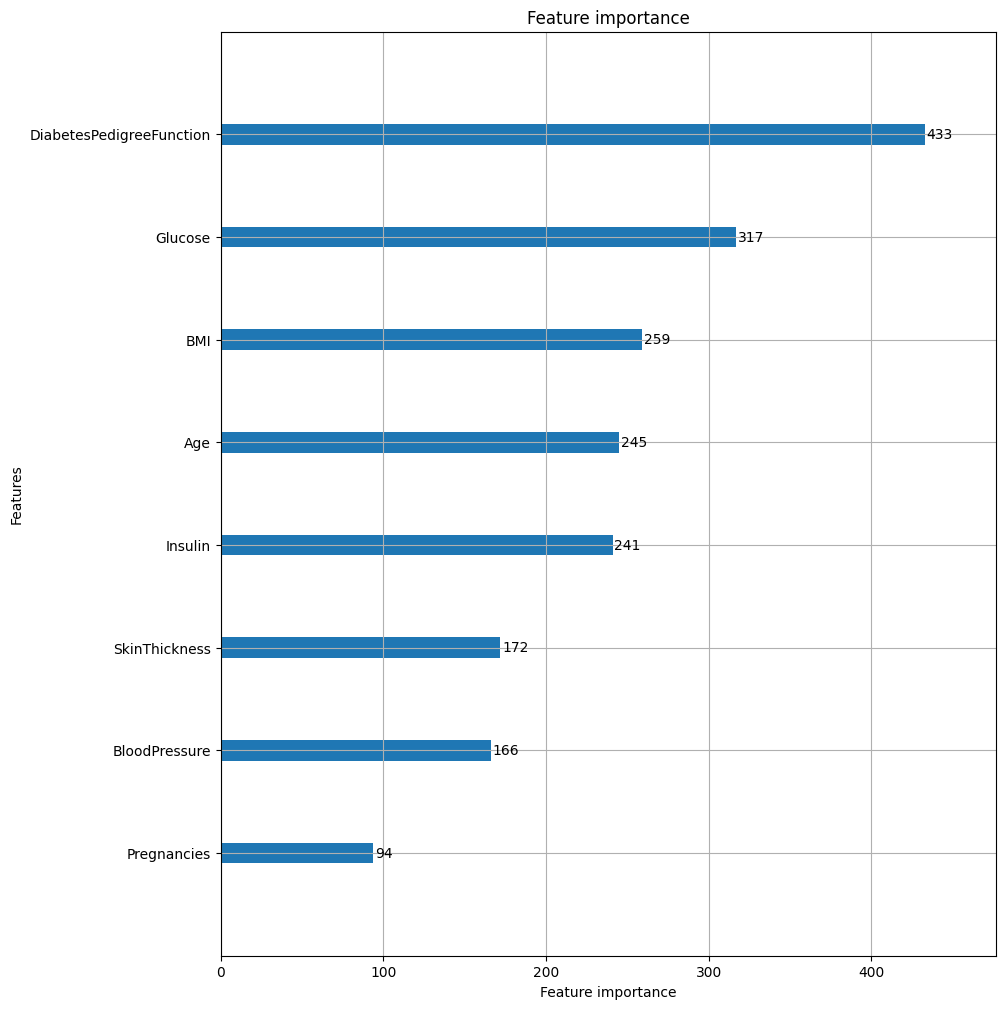

In [ ]:
# plot_importance()를 이용한 피처 중요도 시각화
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

# 4. 스태킹

In [ ]:
# 코드를 실행해주세요
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# 피마 인디언 당뇨병 예측 데이터 세트를 다시 불러옵니다.
diabetes_data = pd.read_csv(r'/content/drive/MyDrive/Euron/diabetes.csv')  # 본인 경로 적게끔

# target value 분리
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# 데이터 셋을 train/test 데이터로 분리 (train:80%, test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)


## 1) 개별 모델과 최종 모델을 생성해주세요.

In [ ]:
# 개별 ML 모델 생성
#
# KNN: n_negihbors=4
# RandomForest: n_estimators=100, random_state=0
# DecisionTree: 별도 하이퍼 파라미터 지정 X
# AdaBoost: n_estimators=100
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델(LogisticRegression: C=10)
lr_final = LogisticRegression(C=10)

## 2) 개별 모델들을 학습시켜 주세요.

In [ ]:
# 개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100)

## 3) 학습된 개별 모델들을 test 데이터를 이용해 예측하고 정확도를 측정해주세요.

In [ ]:
# 개별 모델 예측 및 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

# 정확도 출력
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.6558
랜덤 포레스트 정확도: 0.7662
결정 트리 정확도: 0.7208
에이다부스트 정확도: 0.7208


## 4) 개별 모델들의 예측 결과를 하나로 합친 ndarray를 생성해 pred에 저장한 후 행과 열의 위치를 교환해주세요.

In [ ]:
# 개별 알고리즘의 예측 결과를 ndarry로 변환
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)

## 5) 위에서 만든 새로운 데이터 세트로 최종 메타 모델을 학습시키고 예측한 후 정확도를 출력해주세요.

In [ ]:
# 예측 데이터로 생성된 데이터 세트로 최종 메타 모델 학습 및 예측
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.7597


## 6) CV 세트 기반의 스태킹 모델은 기본 스태킹 모델의 어떤 문제를 개선할 수 있을까요? 이유와 함께 서술하세요.

힌트: 교재 p.282

기본 스태킹 모델은 메타 모델에서 최종 학습할 때 테스트용 데이터 세트를 기반으로 학습하기 때문에 과적합 문제가 발생할 수 있는데, CV 세트 기반의 스태킹은 교차 검증을 기반으로 예측된 결과 데이터 세트를 이용하여 최종 메타 모델을 학습한다. 따라서, 과적합 문제를 개선할 수 있다.

# 5. HyperOpt

- 사이킷런의 `당뇨병 데이터`를 사용합니다.
- 아래의 셀을 실행시킨 후 실습을 진행해 주세요.

In [ ]:
import pandas as pd
import numpy as np
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load dataset

#data_url = "https://www.kaggle.com/datasets/mathchi/diabetes-data-set"


# 1. 다운로드한 CSV 파일을 로컬 경로에서 불러오기
file_path = "/content/drive/MyDrive/"  # 다운로드한 파일 경로로 변경하세요
raw_df = pd.read_csv(file_path+'Euron/diabetes.csv')

# 2. 데이터 처리
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])  # 각 행을 병합
target = raw_df.values[1::2, 2]

## 1) `train_test_split()`를 사용하여 훈련 세트와 테스트 세트로 나누어 주세요.

- random_state = 207
- train: test = 8:2

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=207)

---

- 이제 평가 함수를 정의하겠습니다.  
- 교재와 다르게 Regression 예측을 진행할 예정이기 때문에,` RMSE` 평가 지표를 함수로 만들어 정의합니다.

In [ ]:
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 2) search_space의 빈칸을 채워주세요.

- `max_depth`: 5에서 20까지 1간격으로
- `min_child_weight`: 1에서 10까지 1간격으로  
- `learning_rate`: 0.01에서 0.2 사이 정규 분포 값
- `colsample_bytree`: 0.5에서 1 사이 정규 분포 값

In [ ]:
from hyperopt import hp

# space 정의, Hyperparameter의 이름을 key 값으로 입력
search_space = {
    'max_depth': hp.quniform('max_depth',5,20,1),
    'min_child_weight' : hp.quniform('min_child_weight',1,10,1),
    'learning_rate': hp.uniform('learning_rate',0.01,0.2),
    'colsample_bytree' : hp.uniform('colsample_bytree',0.5,1)
    }

## 3) objective_func의 빈칸을 채워주세요.
- `int` 타입을 가져야 하는 hyperparameter에 주의해 주세요.

In [ ]:
from xgboost import XGBRegressor
from hyperopt import STATUS_OK

In [ ]:
# 목적 함수 정의
def objective_func(search_space):
    model=XGBRegressor(n_estimators=100,
                       max_depth=int(search_space['max_depth']),
                       min_child_weight = int(search_space['min_child_weight']),
                       learning_rate = search_space['learning_rate'],
                       colsample_bytree = search_space['colsample_bytree']
                      )

    evaluation = [(x_train, y_train), (x_test, y_test)]

    model.fit(x_train, y_train,
          eval_set=evaluation,
          verbose=0)

    pred = model.predict(x_test)
    rmse= RMSE(y_test, pred)

    # 평가 방식 선정
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

## 4) 성능 지표에 -1을 곱하지 않는 이유가 무엇일까요?
(hint. 추가 교재 pdf p264)  
(hint2. RMSE는 작을수록 좋은 성능 지표이다.)

목적 함수가 최솟값을 반환하도록 최적화되어있기 때문에 값이 클수록 좋은 성능 지표일 때는 (-1)을 곱해야 한다. 하지만, RMSE는 작을수록 좋은 성능 지표이므로 (-1)을 곱하지 않는다.

## 5) `fmin()`을 이용해 최적 하이퍼 파라미터를 도출하는 과정입니다. 빈칸을 채워주세요

**빈칸을 채워주세요**

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# best에 최적의 하이퍼 파라미터를 return 받습니다.
best = fmin(fn = objective_func,
            space = search_space ,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials,
            rstate=np.random.default_rng(seed=9))

100%|██████████| 50/50 [00:18<00:00,  2.69trial/s, best loss: 14.917796303554304]


In [ ]:
best

{'colsample_bytree': 0.6112847992095296,
 'learning_rate': 0.10210261294668421,
 'max_depth': 17.0,
 'min_child_weight': 7.0}

## 6) 최적의 하이퍼 파라미터를 출력해주세요.  
- 정수형 파라미터는 정수형으로 형변환하고, 실수형 파라미터는 소수점 5자리까지만 변환해주세요

In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'],5), round(best['learning_rate'],5), int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.61128, learning_rate:0.1021, max_depth:17, min_child_weight:7
